In [ ]:
# only run this cell once!
import os 
notebook_path = os.getcwd()
os.chdir(os.path.dirname(notebook_path))

In [ ]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ATLAS)

directory_path = "/global/u2/m/milescb/tracking/traccc-aaS-gpu/client/plots"

In [ ]:
# load data from .npy files
chi2_aas = np.load(os.path.join(directory_path, "chi2.npy"))
ndf_aas = np.load(os.path.join(directory_path, "ndf.npy"))
chi2ndf_aas = np.load(os.path.join(directory_path, "chi2_ndf.npy"))
num_tracks_aas = np.load(os.path.join(directory_path, "num_tracks.npy"))

In [13]:
# get data from .csv files
# Get a list of all chi2_ndf_values_mu*.csv files
chi2_files = glob.glob(f'{directory_path}/chi2_ndf_values_mu*.csv')

# List to hold DataFrames
chi2_dfs = []

for filename in chi2_files:
    # Extract the mu value from the filename
    # Filename format: chi2_ndf_values_muXX.csv
    mu_value = filename.split('_')[-1].replace('.csv', '').replace('mu', '')
    mu_value = int(mu_value)
    
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Add mu as a new column
    df['mu'] = mu_value
    
    # Calculate chi2/ndf
    df['chi2_ndf'] = df['chi2'] / df['ndf']
    
    # Append the DataFrame to the list
    chi2_dfs.append(df)

# Concatenate all DataFrames
chi2_data = pd.concat(chi2_dfs, ignore_index=True)

# Get a list of all num_tracks_mu*.csv files
num_tracks_files = glob.glob(f'{directory_path}/num_tracks_mu*.csv')

# List to hold DataFrames
num_tracks_dfs = []

for filename in num_tracks_files:
    # Extract the mu value from the filename
    # Filename format: num_tracks_muXX.csv
    mu_value = filename.split('_')[-1].replace('.csv', '').replace('mu', '')
    mu_value = int(mu_value)
    
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Add mu as a new column
    df['mu'] = mu_value
    
    # Append the DataFrame to the list
    num_tracks_dfs.append(df)

# Concatenate all DataFrames
num_tracks_data = pd.concat(num_tracks_dfs, ignore_index=True)

In [21]:
chi2_traccc = chi2_data['chi2'].to_numpy()
ndf_traccc = chi2_data['ndf'].to_numpy()
chi2_ndf = chi2_data['chi2_ndf'].to_numpy()
num_tracks_traccc = num_tracks_data['num_tracks'].to_numpy()

In [45]:
def plot_multiple_histograms_with_ratio(variables, bins, range,
                                        xlabel, ylabel, labels, 
                                        save='', histtype='step',
                                        normalize=False, logy=False):

    # Create subplots: 2 rows, 1 column, shared x-axis
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, 
                                            figsize=(7, 8), 
                                            sharex=True,   
                                            gridspec_kw={'height_ratios': [3, 1]})

    # Plot histograms on the top subplot
    histograms = []
    bin_edges = None
    hist_objects = []  # Store histogram objects to get colors

    for i, variable in enumerate(variables):
        hist = ax_top.hist(variable, bins=bins, range=range, 
                          label=labels[i], histtype=histtype, density=normalize)
        histograms.append(hist[0])  # counts
        hist_objects.append(hist[-1][0])  # store histogram object
        if bin_edges is None:
            bin_edges = hist[1]  # edges

    ax_top.set_ylabel(ylabel)
    if logy:
        ax_top.set_yscale('log')
    ax_top.legend()

    # Calculate the ratio w.r.t the first histogram
    reference = histograms[0]
    ratios = []

    for counts in histograms[1:]:
        ratio = np.divide(counts, reference, out=np.ones_like(counts), 
                         where=reference!=0)
        ratios.append(ratio)

    # Plot ratios on the bottom subplot using matching colors
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for i, ratio in enumerate(ratios):
        ax_bottom.step(bin_centers, ratio, where='mid', 
                      label=f"{labels[i+1]} / {labels[0]}", 
                      color=hist_objects[i+1].get_edgecolor())

    ax_bottom.set_xlabel(xlabel)
    ax_bottom.set_ylabel('Ratio', loc='center')

    plt.tight_layout()
    if save != '':
        plt.savefig(save, dpi=300)

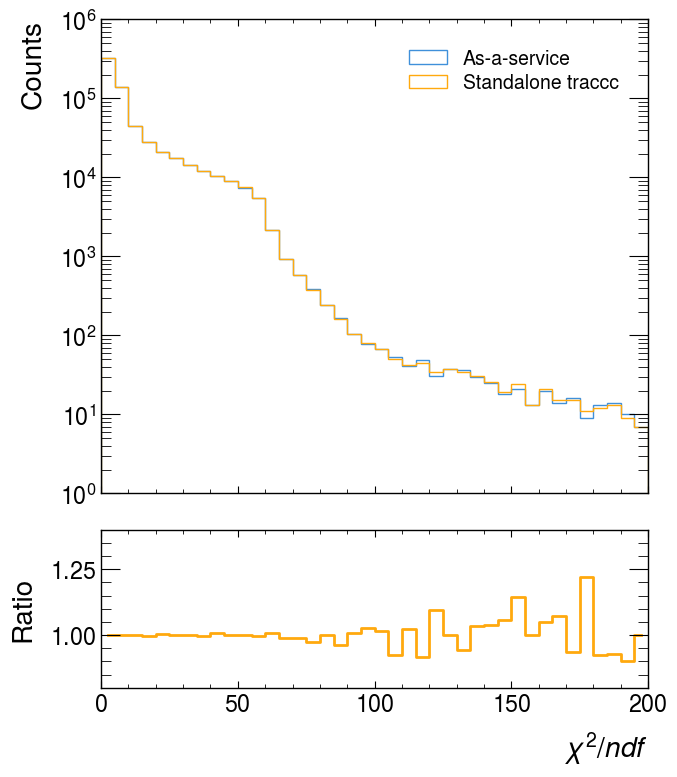

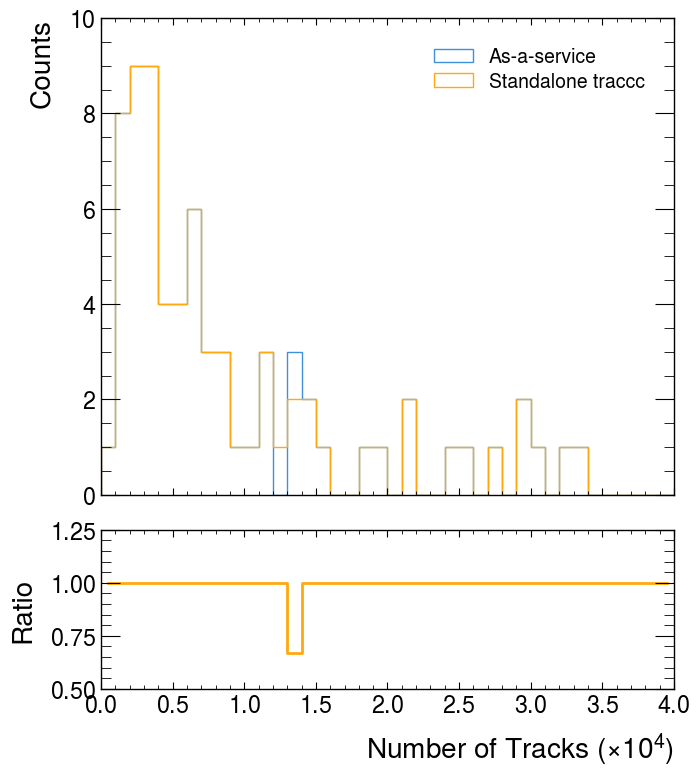

In [ ]:
plot_multiple_histograms_with_ratio([chi2ndf_aas, chi2_ndf], bins=40, range=(0, 200),
                                    xlabel=r"$\chi^2/ndf$", ylabel='Counts', 
                                    labels=['As-a-service', 'Standalone traccc'],
                                    save='', logy=True)
plot_multiple_histograms_with_ratio([num_tracks_aas/1e4, num_tracks_traccc/1e4], bins=20, range=(0, 4),
                                    xlabel=r"Number of Tracks ($\times 10^4$)", ylabel='Counts', 
                                    labels=['As-a-service', 'Standalone traccc'],
                                    save='')

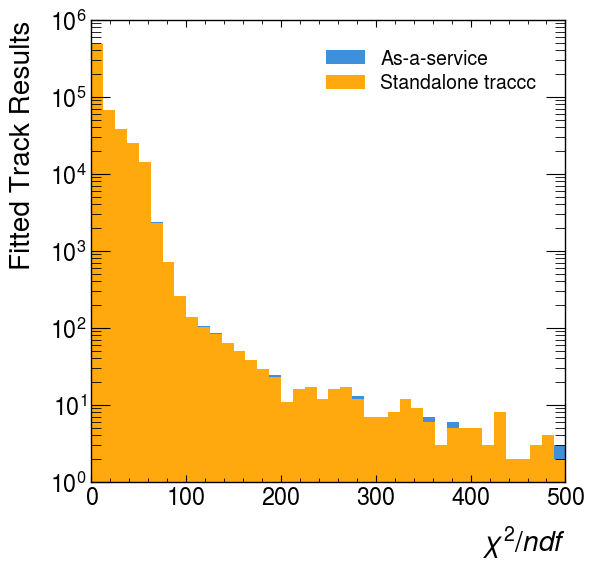

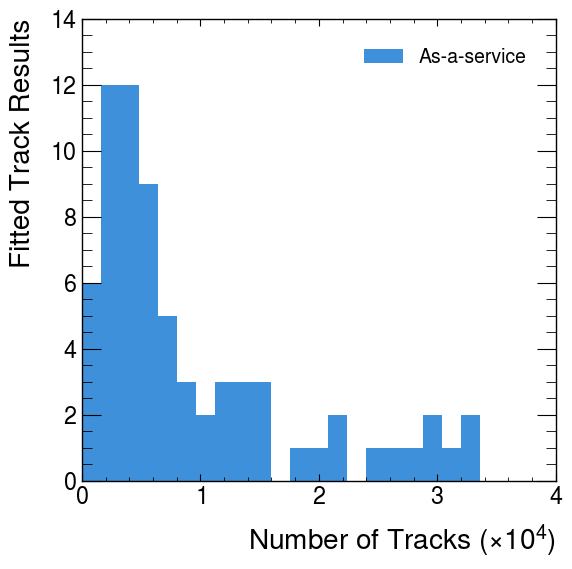

In [42]:
plt.figure(figsize=(6,6))
plt.hist(chi2ndf_aas, bins=40, range=(0, 500), label="As-a-service")
plt.hist(chi2_ndf, bins=40, range=(0, 500), label="Standalone traccc")
plt.xlabel(r"$\chi^2/ndf$", loc="right")
plt.ylabel("Fitted Track Results", loc="top")
plt.yscale("log")
plt.legend()

plt.figure(figsize=(6,6))
plt.hist(num_tracks_aas/1e4, bins=25, range=(0, 4), label="As-a-service")
# plt.hist(num_tracks_traccc/1e4, bins=25, range=(0, 4), label="Standalone traccc")
plt.xlabel(r"Number of Tracks ($\times 10^4$)", loc="right")
plt.ylabel("Fitted Track Results", loc="top")
plt.legend()